# Homework 5
- 姓名： 赵懿
- 学号： 21921266

In [166]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Generate data
First, let's generate 2-d binary class non-linear data set for SVM to classification. I randomly sample points in area $-4 < x_1 < 4, -4 < x_2 < 4$. Those points satisfy $x_1^2-x_2^2 > 1$ is positive (label is +1), othersie is negative (label is -1).

In [167]:
def dataGenerator(size, soft=False):
    data = np.random.rand(2, size) * 8 - 4

    label = data[0]**2 - data[1]**2 - 1
    tmpLabel = label.copy()
    label[tmpLabel < 0] = -1
    label[tmpLabel >= 0] = 1

    # add some pertubation
    if soft:
        mu, sigma = 0, 0.5
        data += np.random.normal(mu, sigma, (2, size))
    return data, label

# visulize generated data
def vis1(data, label):
    Y = np.linspace(-4, 4, 100)
    Xl = np.sqrt(1+Y**2)
    Xr = -Xl
    plt.plot(Xl, Y, c='r')
    plt.plot(Xr, Y, c='r')
    pSet = data[:, label==1]
    nSet = data[:, label==-1]
    plt.scatter(pSet[0], pSet[1], c='b', marker='o')
    plt.scatter(nSet[0], nSet[1], c='y', marker='x')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()

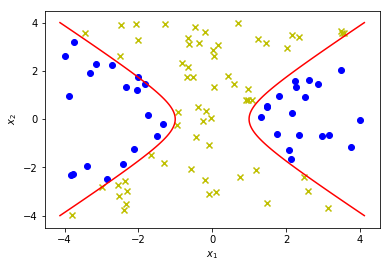

In [168]:
trainSet, trainLabel = dataGenerator(100)
vis1(trainSet, trainLabel)

## Active Set Method (ASM)
> Thanks to
- A intuitive introduce of [Lagrange Multiplier](https://www.zhihu.com/question/38586401/answer/105273125)
- A comprehensible and intuitive [ASM tutorial](https://zhuanlan.zhihu.com/p/29525367)
- An [ASM](https://github.com/akiori/AMCS_HW5/blob/master/svm.py) project on github
 
Next, as the final objective function of SVM can be solved regarded as a quadratic programming problem, let's implement `Active Set Method` algorithm to solve it. Here, my objective of quadratic programming is:
$$
\begin{align}
&x^*=\arg\min_x 1/2x^THx+c^Tx \\
st. \quad &aE^Tx = bE \\
&aI^Tx \leq bI
\end{align}
$$
The i-th equality constraint and inequality constraint can be respectively expressed as:
$$
\begin{align}
&aE[:, i]^Tx = bE[i] \\
&aI[:, i]^Tx \leq bI[i]
\end{align}
$$
If $x \in \mathbb{R}^d$ and we have $N_e$ equality constraints and $N_i$ inequality constraints, then in program, $x, H, c, aE, bE, aI, bI$ is $(d, 1), (d, d), (d, 1), (d, N_e), (N_e, 1), (d, N_i), (N_i, 1)$ shape vector respectively.

In the following function:
- `initX` is an initial feasible solution, shape: (d, 1)
- `initASIdx` is the inital active set that initX satisfies. It is a list whose element with int value `v` represents the `v`-th inequality constraint (aI\[:, v\], bI\[v\]) is in active set.
- `x, H, c, aE, bE, aI, bI` have been discussed above
- `endThr` is algorithm end condition, a float type real number.
- `maxIter` is the maximun iteration number of asm algorithm

More detailed information see code comments.

In [169]:
def asm(initX, initASIdx, H, c, aI, bI, aE, bE, endThr, maxIter):
    x = initX
    ASIdx = initASIdx # active set, apart from all the equality constriants
    dim, _ = x.shape
    iter = 0

    while iter < maxIter:
        # construct active set
        # a (w, n)
        # b (w, 1)
        IWSize = ASIdx.size
        if IWSize == 0:
            a = aE
            b = bE
        else:
            a = np.hstack((aE, aI[:, ASIdx]))
            b = np.vstack((bE, bI[ASIdx]))
        # solve the problem:
        # min x.T@H@x + c.T@x
        # st. a.T@x = b
        _, col = a.shape
        matL = np.vstack((H, a.T))  # (w+n, w)
        matB = np.vstack((a, np.zeros((col, col))))  # (w+n, n)
        left = np.hstack((matL, matB))
        right = np.vstack((-c, b))
        res = np.linalg.solve(left.T, right)
        newX = res[:dim, :]
        lamda = res[dim:, :]
        # get moving vector d
        d = newX - x
        ILamda = lamda[-IWSize:]
        # If have reached the optimum point of current active set
        if np.all(np.abs(d) < endThr):
            # situation 1
            if IWSize == 0: # any inequality constraint is useless
                return x
            if np.all(ILamda >= 0): # find the final optimum solution
                return x
            # situation 2
            # remove the most negative inequality constraint
            # final optimum solution won't be on this constraint's border
            # and solution may go along opposite direction of this constraint
            minIdx = np.argmin(ILamda)
            ASIdx = np.delete(ASIdx, minIdx)
        else:
            # solution can still be optimized under current active set (inequality constraints)
            eps = 1
            minIdx = -1
            # 
            for i in range(aI.shape[1]):
                if i not in ASIdx:
                    if aI[:, i]@d > 0:
                        tmpEps = (bI[i] - aI[:, i]@x)/(aI[:, i]@d)
                        if tmpEps <= eps:
                            eps = tmpEps
                            minIdx = i
            # update x
            x += eps*d
            if minIdx != -1:
                # situation 3
                # some constraints not in current active set does not stands in the way of this 'move step'
                # add this constraint to active set
                ASIdx = np.append(ASIdx, minIdx)
            # situation 4:
            # any constraints not in current active set does not stands in the way of this 'move step'
            # nothing, just x += eps*d
        iter += 1
    return x

## SVM

> Thanks to
- Chapter: 'Support Vector Machine' in 'Statistical Learning Methods' Hang Li
- A detailed [svm tutorial](https://www.jiqizhixin.com/articles/2018-10-17-20)

Anyway, if we don't take the penalty coefficient into consideration, the final objective of SVM is:
$$
\begin{align}
&\min_{\alpha} \frac{1}{2}(\sum_{i=1}^N\sum_{j=1}^N{\alpha_iy_i\alpha_jy_jk(x_i,x_j)}) + \sum_{i=1}^N\alpha_i\\
st. \quad & -\alpha_i \leq 0 \\
& \sum_{i=1}^N\alpha_iy_i = 0
\end{align}
$$
where N is the size of data set; $\alpha_i$ is the Lagrange multiplier of i-th inequality constraint; $y_i$ is the label of $x_i$ (postive: +1, negative:-1); k is the kernel function.

Our goal is to find the optimim $\alpha^*: [\alpha_1, \alpha_2, ..., \alpha_N]$ and $\alpha^*$ and $b*$ are used to predict class of new input.
### kernel function
First, let implement some common(linear, polynomial, gassian) kernel function:

In [170]:
def kernelFunc(x1, x2, name, **kwargs):
    """Vectorized kernel function, compute the kernel value for each the pair (x1_i, x2_j) where x1_i is in x1, x2_j is in x2
    Args:
        x1(ndarray): data set 1, shape (dim, dataset1_size)
        x1(ndarray): data set 2, shape (dim, dataset2_size)
        name(str): kernel function type, 'linear', 'polynomial' and 'gassian' are available
    Return:
        H(ndarray): kernel value, h[i,j] is kernel value of pair (x1_i, x2_j)
    """
    _, num1 = x1.shape
    _, num2 = x2.shape
    xf = np.repeat(x1, num2, axis=1)
    xl = np.tile(x2, num1)

    if name == 'linear':
        H = np.sum(xf*xl, axis=0)
    elif name == 'poly':
        d = 5
        if 'poly_d' in kwargs.keys():
            d = kwargs['poly_d']
        H = (np.sum(xf*xl, axis=0) + 1)**d
    elif name == 'gaussian':
        std = 2
        if 'std' in kwargs.keys():
            std = kwargs['std']
        H = np.exp(-np.sum((xf - xl)**2, axis=0) / (2*(std**2)))
    else:
        raise NotImplementedError

    H = H.reshape((num1, num2))
    return H

### SVM
Next, let implement SVM algorithm. The following steps need to be done:
- prepare args for ASM functoin based on train data set, including coefficents of ASM objective functoin, initial solution and active set
- run ASM, get support vectors, corrosponding Lagrange multipliers and compute $b$
- implement predict function base on support vectors, corrosponding Lagrange multipliers and compute $b$

Detailed information see [SVM working mechanism](https://www.jiqizhixin.com/articles/2018-10-17-20).

In [171]:
class SVM():
    def __init__(self):

        self.kernel = 'linear'
        self.supNum = 0
        self.supAlpha = None
        self.supData = None
        self.supLabel = None
        self.b = None
    
    # train
    def fit(self, data, label, kernel='poly'):
        self.kernel = kernel
        H, c, aI, bI, aE, bE = self.prepare(data, label)
        initX, initASIdx = self.trickInit(aI, bI, label)
        alpha = asm(initX, initASIdx, H, c, aI, bI, aE, bE, endThr=10e-5, maxIter=200)
        supMask = np.squeeze(alpha > 1e-5)
        self.supNum = np.sum(supMask)
        self.supAlpha = np.squeeze(alpha[supMask])
        self.supData = data[:, supMask]
        self.supLabel = label[supMask]
        # compute b
        self.b = np.mean(self.supLabel - \
                         np.sum(kernelFunc(self.supData, self.supData, kernel)*self.supLabel*self.supAlpha, axis=0))

    # val
    def predict(self, testData):
        # testData: (dim, tn)
        # self.supData: (dim, sn)
        label = np.zeros(testData.shape[1])
        kernelValue = kernelFunc(testData, self.supData, self.kernel) #(tn, sn)
        clsValue = kernelValue*self.supAlpha*self.supLabel + self.b
        clsValue = np.sum(clsValue, axis=1)
        label[clsValue > 0] = 1
        label[clsValue < 0] = -1
        return clsValue, label
    
    # prepare coefficents for ASM objective functoin based on train data set
    def prepare(self, data, label):
        dim, num = data.shape

        # get H, c, aI, aE
        # H
        H = kernelFunc(data, data, self.kernel)
        yf = np.repeat(label, num)
        yl = np.tile(label, num)
        H = H*((yf*yl).reshape(num, num))
        # c
        c = np.ones((num, 1)) * -1
        # aI, bI
        # aI.T@x < bI
        aI = np.diag(np.ones(num)) * -1
        bI = np.zeros((num, 1))
        # aE, bE
        # aE.T@x = bE
        aE = label.reshape((num, 1))
        bE = np.zeros((1, 1))

        return H, c, aI, bI, aE, bE
    # prepare initial solution and active set
    def trickInit(self, aI, bI, label):
        # make sure:
        # aI.T@x <= bI
        # aE.T@x = bE

        # get initial x
        initX = np.zeros((len(label), 1))
        maskP = label == 1
        maskN = label == -1
        para1 = np.sum(maskP)
        para2 = np.sum(maskN)
        initX[maskP, 0] = para2
        initX[maskN, 0] = para1
        # get initial active set
        initASIdx = np.where(aI.T@initX - bI == 0)

        return initX, initASIdx[0]

## Experiments

Now all the things are ready, let trian SVM and use it to predict a group of new data.

In [172]:
np.random.seed(567)
trainSet, trainLabel = dataGenerator(100)
testSet, fakeLabel = dataGenerator(100)
svm = SVM()
svm.fit(trainSet, trainLabel, 'gaussian')
pValue, pLabel = svm.predict(testSet)

Visualize train results, including:
- support vecotrs (big black markers)
- decision boundary (red curve)

In [173]:
def visTrain(data, label, svm):
    pSet = data[:, label == 1]
    nSet = data[:, label == -1]
    plt.scatter(pSet[0], pSet[1], c='b', marker='o', label='positive class')
    plt.scatter(nSet[0], nSet[1], c='y', marker='x', label='negtive class')

    pSupVec = svm.supData[:, svm.supLabel == 1]
    nSupVec = svm.supData[:, svm.supLabel == -1]
    plt.scatter(pSupVec[0], pSupVec[1], c='k', s=60, marker='o', label='positive support vector')
    plt.scatter(nSupVec[0], nSupVec[1], c='k', s=60, marker='x', label='negtive support vector')

    x1, x2 = np.meshgrid(np.linspace(-4, 4, 80), np.linspace(-4, 4, 80))
    X = np.array([[x1,  x2] for x1, x2 in zip(np.ravel(x1), np.ravel(x2))])
    pv, pl = svm.predict(X.T)
    pv = pv.reshape(80, 80)
    plt.contour(x1, x2, pv, [0.0], colors='r', linewidths=1, origin='lower', label='classificatoin boundary')
    plt.legend()
    plt.show()

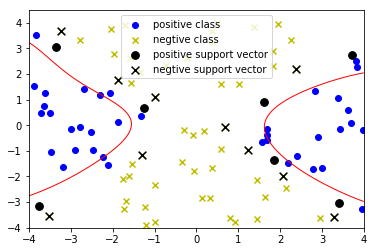

In [174]:
visTrain(trainSet, trainLabel, svm)

Visualize val results

In [175]:
def visTest(data, label):
    pSet = data[:, label == 1]
    nSet = data[:, label == -1]
    plt.scatter(pSet[0], pSet[1], c='b', marker='o', label='positive class')
    plt.scatter(nSet[0], nSet[1], c='y', marker='x', label='negtive class')
    plt.show()

Real classification:


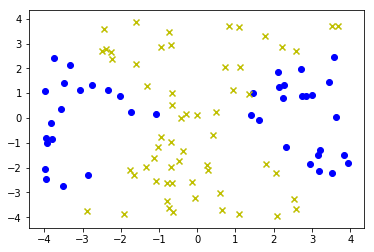

Predicted classification:


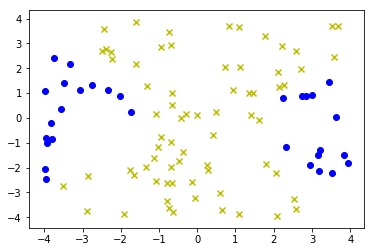

accuracy: 89.0%


In [179]:
print('Real classification:')
visTest(testSet, fakeLabel)
print('Predicted classification:')
visTest(testSet, pLabel)
print('accuracy: {}%'.format(100*np.sum(fakeLabel==pLabel)/len(fakeLabel)))